# 2x2 Coupler

An example creating a 2x2 coupler using gdsfactory's built-in methods. This will mostly be me following the tutorial in the [gdsfactory docs](https://gdsfactory.github.io/gdsfactory/notebooks/meep/001_meep_sparameters.html#parallel-simulation-multicore-mpi).

In [ ]:
import numpy as np

import meep as mp
import gdsfactory as gf
from gdsfactory.generic_tech import get_generic_pdk
import gdsfactory.simulation.gmeep as gm
import gdsfactory.simulation as sim
from gdsfactory.simulation.modes import find_modes_waveguide

gf.config.rich_output()
PDK = get_generic_pdk()
PDK.activate()

## Setup

First we define the materials and geometry in the simulation. This will be a standard silicon-on-insulator design with a 220nm waveguide embedded in SiO2 at a wavelength of 1550nm, and we will ignore the substrate for now.

The device will be a 2x2 port setup and we will use gdsfactory's built-in coupler component with length and gap spacing as prescribed in the [Meep docs](https://meep.readthedocs.io/en/latest/Python_Tutorials/GDSII_Import/#s-parameters-of-a-directional-coupler).

In [33]:
sim_res = 30
n_si = 3.4777
n_sio2 = 1.444
z_wvg = 0.22
lambda0 = 1.55

c = gf.components.coupler(length=8, gap=0.12)

Ideally, we should perform 3D simulations here. However, in the interest of time, we will be doing 2D effective index simulations instead. We calculate the effective index of the fundamental TE mode of the waveguide and use the index of that mode to perform our simulations.

Note that the effective index method is only an approximation and works best in a setting with 1. low refractive index contrast and 2. strongly guided modes, where out-of-plane scattering is not a (big) concern. Since we are looking at a SOI platform here, the effective index method is actually not _great_, as the system has pretty high index contrast. This is somewhat mitigated by the fact that there are only adiabatic interfaces in propagation direction, which means that we do not expect significant out-of-plane scattering. The results should therefore still give a decent indication of device performance.

In [34]:
neff = find_modes_waveguide(
    parity=mp.NO_PARITY,
    wg_width=0.5,
    ncore=n_si,
    nclad=n_sio2,
    wg_thickness=z_wvg,
    resolution=2 * sim_res,
    sy=3,
    sz=3,
    nmodes=1,
)[1].neff
neff = float(neff)
neff

/users/tfp/yaugenst/dev/code/gf_fork/gdsfactory/typings.py:290: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.array(val, dtype=cls.inner_type)


2.446343545419426

## S-parameter calculation

Now we use gdsfactory's Meep integration to obtain the S-parameters of the coupler.

But first, let's visualize simulation layout.

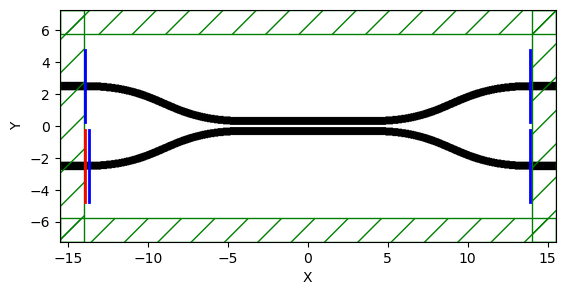

In [35]:
_ = gm.write_sparameters_meep(
    component=c,
    resolution=20,
    is_3d=False,
    material_name_to_meep={"si": neff, "sio2": n_sio2},
    run=False,
)

Now for the actual simulation, using `write_sparameters_meep_mpi` running on 8 cores.

In [ ]:
fp = gm.write_sparameters_meep_mpi(
    component=c,
    resolution=sim_res,
    is_3d=False,
    material_name_to_meep={"si": neff, "sio2": n_sio2},
    cores=8,
    overwrite=True,
)
sp = np.load(fp)

## Results

First, let's plot all obtained S-parameters.

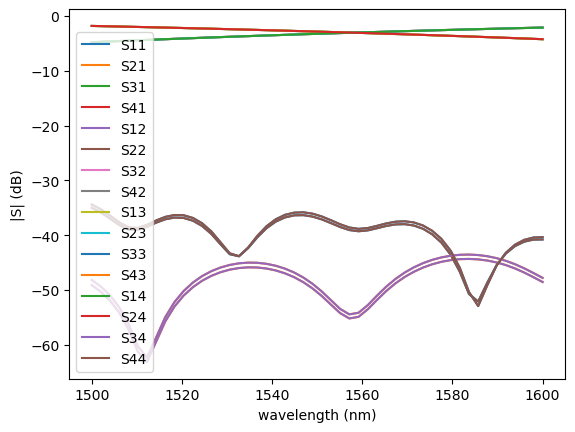

In [37]:
sim.plot.plot_sparameters(sp)

### Excess loss

Now we plot the excess loss. This is just $10 \log(|S_{13}|^2 + |S_{14}|^2)$ and thankfully, gdsfactory has a convenient built-in for that.

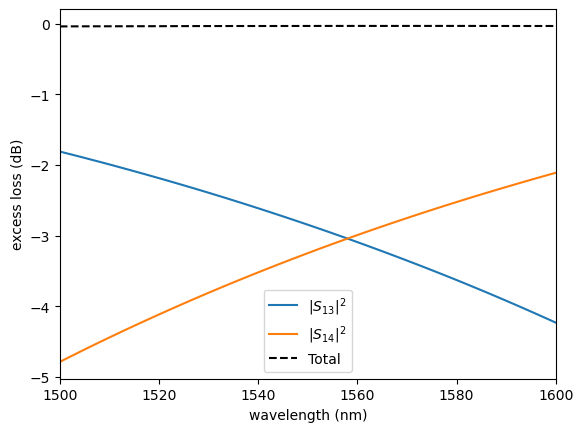

In [38]:
sim.plot.plot_loss2x2(sp)

## Imbalance

The imbalance is the difference between the power in the two output ports, and we define it here as: $10 \log(1 - (|S_{13}|^2 - |S_{14}|^2))$

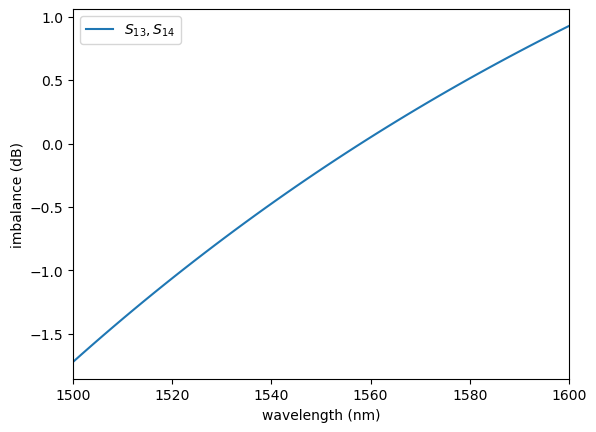

In [39]:
sim.plot.plot_imbalance2x2(sp)

## Reflection

The reflection is captured by the S-parameters $S_{11}$ and $S_{21}$, i.e. the power that is registered by the monitors at the input ports.

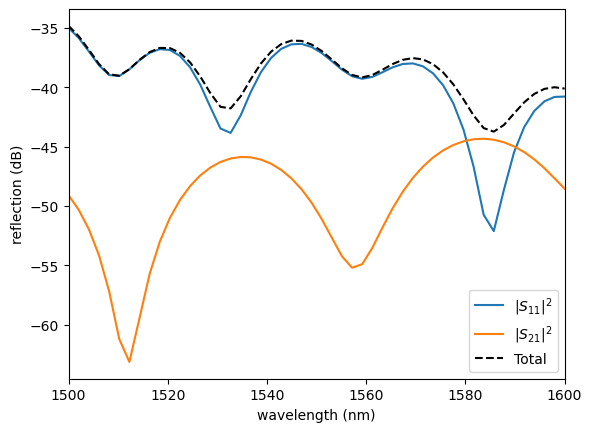

In [40]:
sim.plot.plot_reflection2x2(sp)

## Discussion

We note that the coupler has an imbalance greater than zero at the target wavelength of 1550nm, and the perfect 50/50 splitting is shifted slightly to a higher wavelength of just below 1560nm. The reason for this is most likely the approximation error introduced by the effective index method, which is not a 3D full-wave simulation.